# Проект: Многоцелевая модель для NER + event-CLS

Этот Jupyter-ноутбук - пошаговый шаблон для выполнения проекта по объединённой (multi-task) модели, решающей **NER (BIO, token-level)** и **CLS (document-level multihot событий/отношений)** на датасете NEREL.

Внимание: вам нужно реализовать весь рабочий код - в ноутбуке предустановлены только парсеры строкового формата. Все остальные ячейки служат как инструкции / места для вашего кода.


#### Структура ноутбука 

1. Подготовка окружения (пути, seed, imports)
2. EDA - загрузка jsonl, обзор, графики, выводы 
3. Парсинг и таргеты - здесь уже есть парсеры строкового формата NEREL; нужно реализовать сбор примеров (`build_examples_from_nerel`) 
4. Токенизация, выравнивание меток, DataLoader - реализовать `tokenize_and_align_labels`, Dataset/Collator 
5. Модель (JointModel) и кастомный loss (uncertainty-weighting) - реализовать модельный класс и loss
6. Тренировка/валидация - training loop, оптимизатор, scheduler, логирование метрик
7. Инференс и анализ ошибок - реализовать inference pipeline и примеры



## 1. EDA

Цели:

- Прочитать первые 50–200 записей `train.jsonl` (путь `/data/train.jsonl`).
- Посчитать частоты: entity types, relation/event types.
- Построить графики: топ-15 entity types, распределение длины текстов, число сущностей на документ.
- Написать 2–3 коротких вывода в Markdown: что можно ожидать при моделировании (редкие типы, длинные документы и т. п.).




In [1]:
import json
from collections import Counter
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

In [2]:

# выгружаем первые 200 записей
df = pd.read_json("data/train.jsonl", lines=True, nrows=200)

In [3]:
df.head()

,id,text,entities,relations,links
0,0,"Пулеметы, автоматы и снайперские винтовки изъя...","[T1\tNATIONALITY 62 74\tамериканцами, T2\tCITY...","[R1\tTAKES_PLACE_IN Arg1:T70 Arg2:T12, R2\tAGE...","[N1\tReference T5 Wikidata:Q813\tКиргизия, N2\..."
1,1,Муртаза Рахимов чистит кадры\n\t\nПрезидент Ба...,"[T1\tPERSON 0 15\tМуртаза Рахимов, T2\tPROFESS...","[R1\tWORKS_AS Arg1:T3 Arg2:T76, R2\tWORKS_AS A...","[N1\tReference T9 Wikidata:NULL\t, N2\tReferen..."
2,2,Россия задерживает поставку генсека\n\t\nСегод...,"[T1\tCOUNTRY 0 6\tРоссия, T2\tCITY 48 52\tДохе...","[R1\tALTERNATIVE_NAME Arg1:T4 Arg2:T5, R2\tORG...",[N1\tReference T5 Wikidata:Q1031255\tФорум стр...
3,3,"Российские менеджеры отказались возглавлять ""г...","[T1\tCOUNTRY 0 10\tРоссийские, T2\tORGANIZATIO...","[R1\tALTERNATIVE_NAME Arg1:T80 Arg2:T4, R2\tAL...",[N1\tReference T3 Wikidata:Q6501749\tгенеральн...
4,4,Facebook нашел нового финансового директора\nФ...,"[T1\tORGANIZATION 0 8\tFacebook, T2\tPROFESSIO...","[R1\tAGE_IS Arg1:T6 Arg2:T5, R2\tALTERNATIVE_N...",[N1\tReference T13 Wikidata:Q899140\tGenentech...


In [4]:
entity_counter = Counter()

for entities in df['entities']:
    entity_counter.update(e.split()[1] for e in entities)

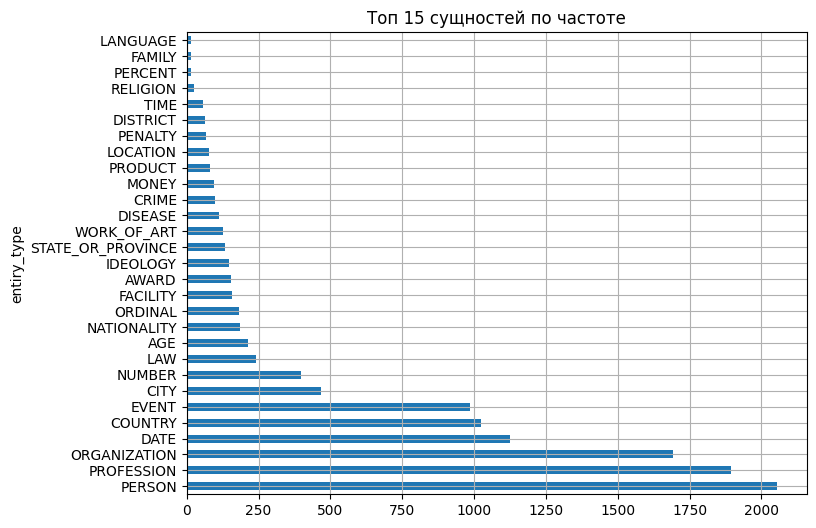

In [5]:
pd.DataFrame(
    entity_counter.most_common(30),
    columns=["entiry_type", "cnt"]
).plot.barh(
    x="entiry_type",
    y="cnt",
    figsize=(8, 6),
    legend=False,
    grid=True,
    title='Топ 15 сущностей по частоте'
);

In [6]:
relation_counter = Counter()

for relations in df['relations']:
    relation_counter.update(
        r.split("\t")[1].split()[0] for r in relations
    )

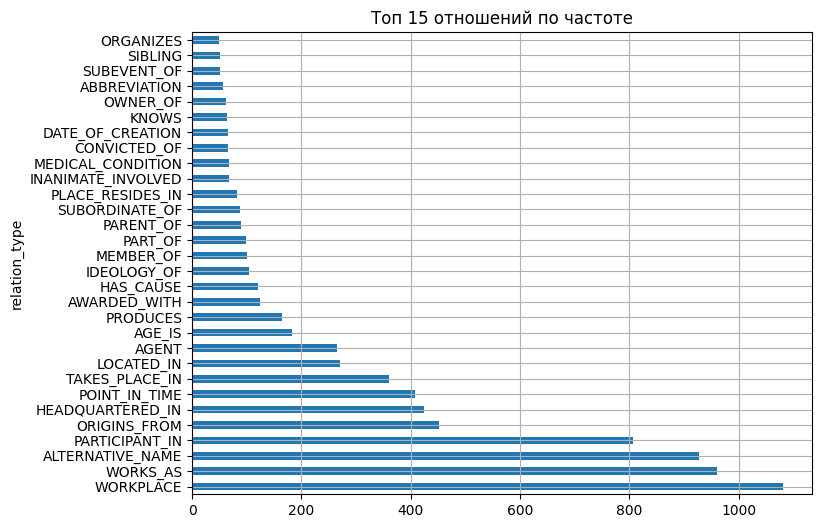

In [7]:
pd.DataFrame(
    relation_counter.most_common(30),
    columns=["relation_type", "cnt"]
).plot.barh(
    x="relation_type",
    y="cnt",
    figsize=(8, 6),
    legend=False,
    grid=True,
    title='Топ 15 отношений по частоте'
);

In [8]:
df['text_len'] = df['text'].map(len)

Минимальная длина текста: 537
Медианная длина текста: 1484
95% текстов имеют длину в интервале [537, 2872]
Тексты большей длины можно рассматривать как выбросы.


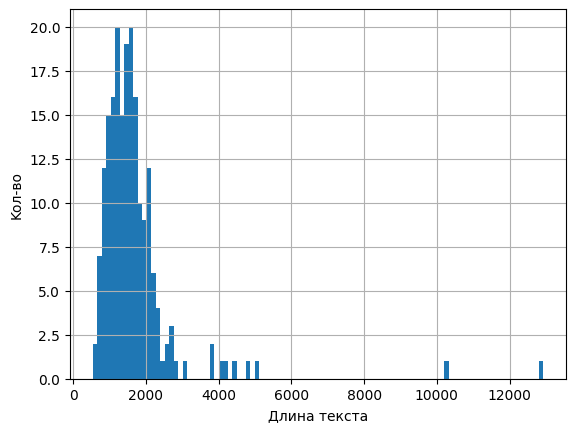

In [9]:
low, high = df['text_len'].quantile([0.0, 0.95])
median = df['text_len'].median()

print(f"Минимальная длина текста: {low:.0f}")
print(f"Медианная длина текста: {median:.0f}")

print(f"95% текстов имеют длину в интервале [{low:.0f}, {high:.0f}]")
print("Тексты большей длины можно рассматривать как выбросы.")


df['text_len'].hist(bins=100)
plt.xlabel("Длина текста")
plt.ylabel("Kол-во");

In [10]:
# кол-во сущностей 
df['cnt_entities'] = df['entities'].map(len)

Минимальное кол-во сущностей: 11
Медианное кол-во сущноестей: 53
95% текстов имеют кол-во сущностей в интервале [11, 113]


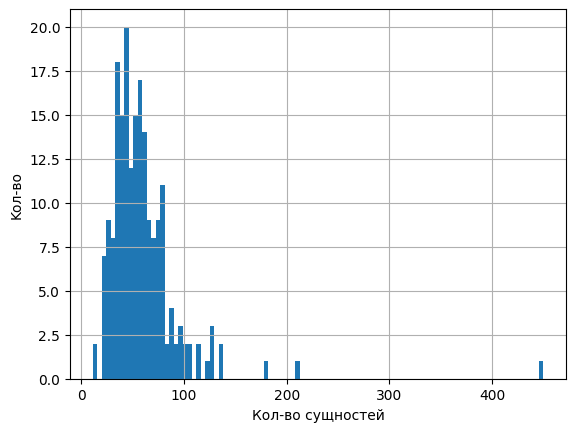

In [11]:
low, high = df['cnt_entities'].quantile([0.0, 0.95])
median = df['cnt_entities'].median()

print(f"Минимальное кол-во сущностей: {low:.0f}")
print(f"Медианное кол-во сущноестей: {median:.0f}")

print(f"95% текстов имеют кол-во сущностей в интервале [{low:.0f}, {high:.0f}]")

df['cnt_entities'].hist(bins=100)
plt.xlabel("Кол-во сущностей")
plt.ylabel("Kол-во");

## Выводы

- Наблюдается сильный дисбаланс по типам сущностей и отношений. Это может привести к тому, что модель будет лучше распознавать частые классы и хуже редкие.
- Большинство документов короче 3000 символов, однако есть и сильные выбросы длиной более 10000. При обучении моделей с ограниченным контекстным окном такие тексты могут требовать усечения или разбиения на части, что потенциально приводит к потере части разметки.
- Число сущностей в большинстве документов менее 110. Но встречаются документы и выбросы на 400+ сущностей. Тексты с высокой плотностью сущностей могут представлять повышенную сложность для модели, так как требуют точного распознавания большого количества сущностей в одном контексте.


## Парсинг и подготовка таргетов

Ниже - две заранее подготовленные функции парсинга строкового формата NEREL. Их вы получаете и можете использовать сразу (не меняйте имена).

Ожидаемые дополнительные функции, которые вы должны реализовать:

- `build_examples_from_nerel(records: List[dict], event_list: List[str]) -> List[dict]` - для каждого документа вернуть словарь с полями: `text`, `tokens` (word-tokenization по пробелам), `token_spans` (символьные оффсеты слов), `tags` (BIO per token), `cls_vec` (multihot длиной len(event_list)).

- `make_event_list(records, K=30)` - собрать топ-K типов событий/relations и вернуть список.



**Правила BIO и сопоставления:**

- Токенизация для BIO - простая `text.split()` (по пробелам). Офсеты токенов вычисляются на основе поиска токена в тексте (учтите повторы; используйте скользящий указатель).
- Для каждой сущности (start, end - символьные оффсеты) пометьте токены, которые пересекаются с интервалом сущности.
- Метки: `B-TYPE`, `I-TYPE`, `O`.



In [12]:

import re
from collections import Counter

# Функции парсинга строкового формата NEREL
def parse_entity_line(line: str):
    parts = line.split('\t')
    if len(parts) < 3:
        return None
    ent_id = parts[0].strip()
    type_pos = parts[1].strip()
    text = parts[2].strip() if len(parts) > 2 else ''
    m = re.match(r'(\S+)\s+(\d+)\s+(\d+)', type_pos)
    if not m:
        return None
    ent_type = m.group(1)
    start = int(m.group(2))
    end = int(m.group(3))
    return {'id': ent_id, 'type': ent_type, 'start': start, 'end': end, 'text': text}

def parse_relation_line(line: str):
    parts = line.split('\t')
    if len(parts) < 2:
        return None
    rel_id = parts[0].strip()
    body = parts[1].strip()
    m = re.match(r'(\S+)\s+Arg1:(\S+)\s+Arg2:(\S+)', body)
    if not m:
        return None
    rel_type = m.group(1)
    arg1 = m.group(2); arg2 = m.group(3)
    return {'id': rel_id, 'type': rel_type, 'arg1': arg1, 'arg2': arg2}



In [13]:
def get_records(str_path):
    path = Path(str_path)  
    records = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            records.append(json.loads(line))
    return records

def parse_entity_and_relations(records):
    for r in records:
        r['entities'] = [parse_entity_line(e) for e in r.get('entities', [])]
        r['relations'] = [parse_relation_line(e) for e in r.get('relations', [])]
    return records



In [14]:
def make_event_list(records, K=None):
    def _get_types(field):
        counter = Counter()
        for r in records:
            for item in r.get(field, []):
                counter[item['type']] += 1

        if K is None:
            return list(counter.keys())
        else:
            return [key for key, _ in counter.most_common(K)]

    return _get_types('relations'), _get_types('entities')

In [15]:
train_records = get_records("data/train.jsonl")
test_records = get_records("data/test.jsonl")

print("Кол-во записий в train:", len(train_records))
print("Кол-во записий в test:", len(test_records))

Кол-во записий в train: 746
Кол-во записий в test: 93


In [16]:
train_records = parse_entity_and_relations(train_records)
test_records = parse_entity_and_relations(test_records)

In [17]:
relations, entities =  make_event_list(train_records)

In [18]:
print(relations[:5])
print(entities[:5])

['TAKES_PLACE_IN', 'AGE_IS', 'HEADQUARTERED_IN', 'ORGANIZES', 'LOCATED_IN']
['NATIONALITY', 'CITY', 'DATE', 'COUNTRY', 'ORGANIZATION']


In [19]:
from typing import List

def build_examples_from_nerel(records: List[dict], event_list: List[str]) -> List[dict]:
    event2idx = {e: i for i, e in enumerate(event_list)}
    examples = []

    for r in records:
        text = r['text']
        tokens = r['text'].split()

        # token_spans
        token_spans = []
        start_from = 0
        for t in tokens:
            span_start = text.find(t, start_from)
            span_end = span_start + len(t)
            token_spans.append((span_start, span_end))
            start_from = span_end
        
        # BIO
        token_labels = ["O"] * len(tokens)

        for ent in r.get("entities", []):
            init_type = ent["type"]
            span_start = ent["start"]
            span_stop = ent["end"]

            pos_ids = []
            for i, (ts0, ts1) in enumerate(token_spans):
                if ts0 < span_stop and ts1 > span_start:
                    pos_ids.append(i)

            if len(pos_ids) == 0:
                continue

            free_ids = [tid for tid in pos_ids if token_labels[tid] == "O"]
            if len(free_ids) == 0:
                continue
            
            token_labels[free_ids[0]] = "B-" + init_type
            for tid in free_ids[1:]:
                token_labels[tid] = "I-" + init_type

        # cls_vec 
        cls_vec = [0] * len(event_list)
        for rel in r.get("relations", []):
            rel_type = rel["type"]
            idx = event2idx.get(rel_type)
            if idx is not None:
                cls_vec[idx] = 1

        examples.append({
            "text": text,
            "tokens": tokens,
            "token_spans": token_spans,
            "tags": token_labels,
            "cls_vec": cls_vec,
        })

    return examples

In [20]:
train_examples = build_examples_from_nerel(train_records, event_list=relations)
test_examples = build_examples_from_nerel(test_records, event_list=relations)

In [21]:
print('Проверка разметки')
top_n = 20
i = 0

for tok, tag in zip(train_examples[i]['tokens'][:top_n], train_examples[i]['tags'][:top_n]):
    print(f"{tok:<20} {tag}")

Проверка разметки
Пулеметы,            O
автоматы             O
и                    O
снайперские          O
винтовки             O
изъяты               O
в                    O
арендуемом           O
американцами         B-NATIONALITY
доме                 O
в                    O
Бишкеке              B-CITY
05/08/2008           B-DATE
10:35                B-TIME
БИШКЕК,              B-CITY
5                    B-DATE
августа              I-DATE
/Новости-Грузия/.    B-COUNTRY
Правоохранительные   B-ORGANIZATION
органы               I-ORGANIZATION


## 3. Токенизация и выравнивание меток

Задачи:

- Выбрать `AutoTokenizer(..., use_fast=True)`.
- Реализовать `tokenize_and_align_labels(examples, tokenizer, label2id, max_length)`:
  - Токенизировать текст (return_offsets_mapping
  - Преобразовать word-level BIO метки в token-level метки (subword → label = -100 / ignore_index, для первых субтокенов ставится соответствующий тег `B-`/`I-`)
  - Вернуть словарь с `input_ids`, `attention_mask`, `labels` (token-level), `cls_labels`

- Собрать `torch.utils.data.Dataset` и `DataLoader`. Можно использовать `DataCollatorForTokenClassification` либо сделать кастомный collator, который возвращает батчи с `cls_labels`.



In [22]:
from transformers import AutoTokenizer

model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

/opt/miniconda3/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
unique_labels = set()
for ex in train_examples:
    unique_labels.update(ex["tags"])
unique_labels.add("O")

label_list = sorted(unique_labels)
label2id = {lab: i for i, lab in enumerate(label_list)}
id2label = {i: lab for lab, i in label2id.items()}

In [24]:
def tokenize_and_align_labels(examples_batch):
    tokenized = tokenizer(
        examples_batch["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=123,
        return_offsets_mapping=True,   
    )

    labels = []
    for i, word_labels in enumerate(examples_batch["tags"]):
        word_ids = tokenized.word_ids(batch_index=i)

        label_ids = []
        prev_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif prev_word_idx != word_idx:
                label_ids.append(label2id[word_labels[word_idx]])
            else:
                label_ids.append(-100)
            prev_word_idx = word_idx

        labels.append(label_ids)

    tokenized["labels"] = labels
    tokenized["cls_labels"] = examples_batch["cls_vec"]
    return tokenized


In [25]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict({
    "train": Dataset.from_list(train_examples),
    "test": Dataset.from_list(test_examples),
})

In [26]:
tokenized_dataset = dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=["text", "tokens", "token_spans", "tags", "cls_vec"]
)

Map: 100%|██████████| 93/93 [00:00<00:00, 1821.24 examples/s]


In [27]:
print(tokenized_dataset)
print(tokenized_dataset["train"][0].keys())
print(tokenized_dataset["train"][0])

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'labels', 'cls_labels'],
        num_rows: 746
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'labels', 'cls_labels'],
        num_rows: 93
    })
})
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'labels', 'cls_labels'])
{'input_ids': [101, 524, 63602, 50362, 10292, 117, 541, 94454, 27159, 12202, 549, 558, 19147, 29633, 14354, 88504, 41335, 10648, 10387, 89982, 12202, 543, 40585, 92154, 10227, 12579, 10364, 541, 33930, 15238, 23716, 10508, 44838, 543, 42578, 10205, 10831, 120, 11052, 120, 10203, 10150, 131, 10803, 510, 27735, 40051, 14736, 45224, 14736, 117, 126, 14165, 120, 78718, 12189, 118, 512, 14360, 22685, 120, 119, 524, 86310, 51823, 32229, 42528, 79987, 519, 23312, 14122, 28791, 13248, 37235, 10227, 50080, 543, 44838, 117, 40585, 92154, 10227, 12579, 10364, 77879

In [28]:
from transformers import DataCollatorForTokenClassification
from torch.utils.data import DataLoader
import torch


data_collator = DataCollatorForTokenClassification(
    tokenizer=tokenizer,
    padding=True
)

def collactor_with_cls(batch):

    cls_labels = torch.tensor(
        [x["cls_labels"] for x in batch],
        dtype=torch.float
    )

    for x in batch:
        x.pop("cls_labels")

    batch = data_collator(batch)
    batch["cls_labels"] = cls_labels
    return batch

In [29]:
train_dataloader = DataLoader(
    tokenized_dataset["train"],
    batch_size=16,
    shuffle=True,
    collate_fn=data_collator
)

test_dataloader = DataLoader(
    tokenized_dataset["test"],
    batch_size=16,
    shuffle=False,
    collate_fn=data_collator
)

In [30]:
batch = next(iter(train_dataloader))

print("input_ids shape:", batch["input_ids"].shape)
print("labels shape:   ", batch["labels"].shape)
print("cls_labels in batch:" , "cls_labels" in batch)

input_ids shape: torch.Size([16, 123])
labels shape:    torch.Size([16, 123])
cls_labels in batch: True


In [31]:
labels = batch["labels"]
labels

tensor([[-100,   56, -100,  ...,   56,   56, -100],
        [-100,   22,   50,  ...,   56, -100, -100],
        [-100,    8, -100,  ..., -100,   56, -100],
        ...,
        [-100,   19, -100,  ...,    2, -100, -100],
        [-100,   22, -100,  ..., -100, -100, -100],
        [-100,   24, -100,  ...,   24,   52, -100]])

In [32]:
top_n = 30
i = 0

input_ids = batch["input_ids"][i]
labels_i = batch["labels"][i]

tokens = tokenizer.convert_ids_to_tokens(input_ids)

for tok, lab in zip(tokens[:top_n], labels_i[:top_n]):
    print(f"{tok:<15} {lab}")

[CLS]           -100
СМИ             56
:               -100
К               19
##рем           -100
##ль            -100
об              56
##ман           -100
##ул            -100
А               22
.               -100
К               -100
##уд            -100
##рина          -100
,               -100
обе             56
##щая           -100
ему             56
пост            56
премьера        24
после           56
выборов         8
Ми              24
##нис           -100
##тр            -100
ф               52
##ина           -100
##нсов          -100
Алексей         22
К               50


In [33]:
train_example = tokenized_dataset["train"][0]

print("cls_labels length:", len(train_example["cls_labels"]))
print("cls_labels:", train_example["cls_labels"][:10])

cls_labels length: 49
cls_labels: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


##### 4. Модель: `JointModel` + custom loss (uncertainty weighting)


In [34]:
import torch
import torch.nn as nn
from transformers import AutoModel

class JointModel(nn.Module):
    """Joint multi-task модель: NER + multi-label классификация событий (multihot)"""

    def __init__(self, model_name: str, num_token_labels: int, num_cls_labels: int, dropout: float = 0.1, use_uncertainty_weight: bool = False):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name)
        hidden_size = self.model.config.hidden_size

        self.dropout = nn.Dropout(dropout)
        self.token_cls = nn.Linear(hidden_size, num_token_labels)
        self.cls_cls = nn.Linear(hidden_size, num_cls_labels)

        self.token_loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
        self.cls_loss_fct = nn.BCEWithLogitsLoss()

        self.use_uncertainty_weight = use_uncertainty_weight
        self.log_sigma_token = nn.Parameter(torch.tensor(0.0))
        self.log_sigma_cls = nn.Parameter(torch.tensor(0.0))

    def forward(self, input_ids, attention_mask, token_type_ids=None, labels=None, cls_labels=None):
        outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    token_type_ids=token_type_ids,
                )
        
        last_hidden = outputs.last_hidden_state
        token_logits = self.token_cls(self.dropout(last_hidden))

        cls_repr = last_hidden[:, 0]
        cls_logits = self.cls_cls(self.dropout(cls_repr)) 
        
        loss = None
        token_loss = None
        cls_loss = None
            
        if labels is not None and cls_labels is not None:
            token_loss = self.token_loss_fct(
                token_logits.view(-1, token_logits.size(-1)),
                labels.view(-1)
            )

            cls_loss = self.cls_loss_fct(cls_logits, cls_labels.float())

            if self.use_uncertainty_weight:
                loss_token_term = torch.exp(-2.0 * self.log_sigma_token) * token_loss + self.log_sigma_token
                loss_cls_term = torch.exp(-2.0 * self.log_sigma_cls) * cls_loss + self.log_sigma_cls
                loss = loss_token_term + loss_cls_term
            else:
                loss = token_loss + cls_loss

        return {
        "loss": loss,
        "token_loss": token_loss,
        "cls_loss": cls_loss,
        "token_logits": token_logits,
        "cls_logits": cls_logits,
    }

In [35]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

mps


In [37]:
model = JointModel(
    model_name=model_name,
    num_token_labels=len(label2id),
    num_cls_labels=len(relations),
    dropout=0.1,
    use_uncertainty_weight=True,
).to(device)

/opt/miniconda3/envs/nlp/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/miniconda3/envs/nlp/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /opt/miniconda3/envs/nlp/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/opt/miniconda3/envs/nlp/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/miniconda3/envs/nlp/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/miniconda3/envs/nlp/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/miniconda3/envs/nlp/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` in

In [38]:
batch = next(iter(train_dataloader))
for k in batch:
    batch[k] = batch[k].to(device)

out = model(
    input_ids=batch["input_ids"],
    attention_mask=batch["attention_mask"],
    token_type_ids=batch.get("token_type_ids", None),
    labels=batch["labels"],
    cls_labels=batch["cls_labels"],
)

print(out["token_logits"].shape, out["cls_logits"].shape, out["loss"].item())

torch.Size([16, 123, 57]) torch.Size([16, 49]) 5.095481872558594


##### 5. Training / Validation



In [39]:
import numpy as np
from sklearn.metrics import f1_score, precision_recall_fscore_support
import torch

def evaluate_joint_model(dataloader, model, device, cls_threshold=0.5):
    """
    Считает метрики на dataloader:
    - token_f1_macro: macro F1 по token-level меткам (игнорируем -100)
    - cls_p_micro / cls_r_micro / cls_f1_micro: micro метрики по flatten multihot
    """
    token_true = []
    token_pred = []

    cls_true = []
    cls_pred = []

    model.eval()

    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}

            out = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                token_type_ids=batch.get("token_type_ids"),
                labels=batch["labels"],
                cls_labels=batch["cls_labels"],
            )

            token_preds = torch.argmax(out["token_logits"], dim=-1)  
            labels = batch["labels"]                                

            for i in range(labels.size(0)):
                for j in range(labels.size(1)):
                    t = labels[i, j].item()
                    if t == -100:
                        continue
                    token_true.append(int(t))
                    token_pred.append(int(token_preds[i, j].item()))

            probs = torch.sigmoid(out["cls_logits"])
            preds = (probs >= cls_threshold).long()

            cls_true.append(batch["cls_labels"].detach().cpu().numpy().astype(int))
            cls_pred.append(preds.detach().cpu().numpy().astype(int))

    token_f1 = f1_score(token_true, token_pred, average="macro", zero_division=0)

    cls_true = np.concatenate(cls_true, axis=0).ravel()
    cls_pred = np.concatenate(cls_pred, axis=0).ravel()

    
    cls_precision, cls_recall, cls_f1, _ = precision_recall_fscore_support(
        cls_true, cls_pred, average="micro", zero_division=0
    )

    return {
        "token_f1": float(token_f1),
        "cls_f1_micro": float(cls_f1),
    }


In [40]:
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm
from torch.nn.utils import clip_grad_norm_
import math
import torch

num_epochs = 50
batch_size = 16
learning_rate = 5e-5

accumulation_steps = 2
warmup_ratio = 0.1
grad_clip = 1.0

In [41]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

num_update_steps_per_epoch = math.ceil(len(train_dataloader) / accumulation_steps)
num_training_steps = num_epochs * num_update_steps_per_epoch
num_warmup_steps = int(warmup_ratio * num_training_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

print("update_steps/epoch:", num_update_steps_per_epoch)
print("training_steps:", num_training_steps)
print("warmup_steps:", num_warmup_steps)

update_steps/epoch: 24
training_steps: 1200
warmup_steps: 120


In [42]:
logs = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    n_batches = 0

    optimizer.zero_grad()

    for i, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}")):
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            token_type_ids=batch.get("token_type_ids"),
            labels=batch["labels"],
            cls_labels=batch["cls_labels"],
        )

        loss = outputs["loss"]
        loss = loss / accumulation_steps
        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            clip_grad_norm_(model.parameters(), grad_clip)

            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps
        n_batches += 1

    if n_batches % accumulation_steps != 0:
        clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    avg_loss = total_loss / n_batches if n_batches > 0 else 0.0


    metrics = evaluate_joint_model(
        dataloader=test_dataloader,
        model=model,
        device=device,
        cls_threshold=0.5,
    )

    logs.append({
        "epoch": epoch + 1,
        "train_loss": avg_loss,
        "token_f1": metrics["token_f1"],
        "cls_f1_micro": metrics["cls_f1_micro"],
    })

    print(
        f"Epoch {epoch + 1}: "
        f"loss={avg_loss:.4f}, "
        f"token_f1={metrics['token_f1']:.4f}, "
        f"cls_f1_micro={metrics['cls_f1_micro']:.4f}"
    )

Epoch 1: 100%|██████████| 47/47 [00:12<00:00,  3.90it/s]


Epoch 1: loss=4.4214, token_f1=0.0116, cls_f1_micro=0.5482


Epoch 2: 100%|██████████| 47/47 [00:11<00:00,  4.20it/s]


Epoch 2: loss=2.8193, token_f1=0.0884, cls_f1_micro=0.8060


Epoch 3: 100%|██████████| 47/47 [00:11<00:00,  4.27it/s]


Epoch 3: loss=1.7705, token_f1=0.2024, cls_f1_micro=0.8244


Epoch 4: 100%|██████████| 47/47 [00:11<00:00,  4.21it/s]


Epoch 4: loss=1.2177, token_f1=0.3665, cls_f1_micro=0.8242


Epoch 5: 100%|██████████| 47/47 [00:11<00:00,  4.18it/s]


Epoch 5: loss=0.9284, token_f1=0.4565, cls_f1_micro=0.8247


Epoch 6: 100%|██████████| 47/47 [00:11<00:00,  4.26it/s]


Epoch 6: loss=0.7497, token_f1=0.5331, cls_f1_micro=0.8361


Epoch 7: 100%|██████████| 47/47 [00:11<00:00,  3.94it/s]


Epoch 7: loss=0.6335, token_f1=0.5616, cls_f1_micro=0.8398


Epoch 8: 100%|██████████| 47/47 [00:13<00:00,  3.58it/s]


Epoch 8: loss=0.5571, token_f1=0.6137, cls_f1_micro=0.8435


Epoch 9: 100%|██████████| 47/47 [00:14<00:00,  3.17it/s]


Epoch 9: loss=0.5001, token_f1=0.6101, cls_f1_micro=0.8440


Epoch 10: 100%|██████████| 47/47 [00:16<00:00,  2.90it/s]


Epoch 10: loss=0.4539, token_f1=0.6344, cls_f1_micro=0.8457


Epoch 11: 100%|██████████| 47/47 [00:17<00:00,  2.63it/s]


Epoch 11: loss=0.4203, token_f1=0.6251, cls_f1_micro=0.8462


Epoch 12: 100%|██████████| 47/47 [00:17<00:00,  2.61it/s]


Epoch 12: loss=0.3953, token_f1=0.6374, cls_f1_micro=0.8462


Epoch 13: 100%|██████████| 47/47 [00:16<00:00,  2.80it/s]


Epoch 13: loss=0.3670, token_f1=0.6368, cls_f1_micro=0.8497


Epoch 14: 100%|██████████| 47/47 [00:15<00:00,  3.02it/s]


Epoch 14: loss=0.3475, token_f1=0.6761, cls_f1_micro=0.8479


Epoch 15: 100%|██████████| 47/47 [00:15<00:00,  3.06it/s]


Epoch 15: loss=0.3265, token_f1=0.6748, cls_f1_micro=0.8512


Epoch 16: 100%|██████████| 47/47 [00:14<00:00,  3.15it/s]


Epoch 16: loss=0.3139, token_f1=0.6386, cls_f1_micro=0.8506


Epoch 17: 100%|██████████| 47/47 [00:14<00:00,  3.18it/s]


Epoch 17: loss=0.2973, token_f1=0.6778, cls_f1_micro=0.8503


Epoch 18: 100%|██████████| 47/47 [00:14<00:00,  3.20it/s]


Epoch 18: loss=0.2816, token_f1=0.6812, cls_f1_micro=0.8506


Epoch 19: 100%|██████████| 47/47 [00:14<00:00,  3.31it/s]


Epoch 19: loss=0.2658, token_f1=0.6692, cls_f1_micro=0.8519


Epoch 20: 100%|██████████| 47/47 [00:14<00:00,  3.24it/s]


Epoch 20: loss=0.2505, token_f1=0.6392, cls_f1_micro=0.8499


Epoch 21: 100%|██████████| 47/47 [00:14<00:00,  3.30it/s]


Epoch 21: loss=0.2370, token_f1=0.6713, cls_f1_micro=0.8503


Epoch 22: 100%|██████████| 47/47 [00:13<00:00,  3.37it/s]


Epoch 22: loss=0.2258, token_f1=0.6722, cls_f1_micro=0.8481


Epoch 23: 100%|██████████| 47/47 [00:14<00:00,  3.34it/s]


Epoch 23: loss=0.2160, token_f1=0.6744, cls_f1_micro=0.8488


Epoch 24: 100%|██████████| 47/47 [00:14<00:00,  3.35it/s]


Epoch 24: loss=0.2064, token_f1=0.6604, cls_f1_micro=0.8545


Epoch 25: 100%|██████████| 47/47 [00:13<00:00,  3.40it/s]


Epoch 25: loss=0.1924, token_f1=0.6675, cls_f1_micro=0.8499


Epoch 26: 100%|██████████| 47/47 [00:13<00:00,  3.43it/s]


Epoch 26: loss=0.1847, token_f1=0.6565, cls_f1_micro=0.8499


Epoch 27: 100%|██████████| 47/47 [00:13<00:00,  3.40it/s]


Epoch 27: loss=0.1741, token_f1=0.6462, cls_f1_micro=0.8499


Epoch 28: 100%|██████████| 47/47 [00:13<00:00,  3.40it/s]


Epoch 28: loss=0.1653, token_f1=0.6696, cls_f1_micro=0.8479


Epoch 29:  15%|█▍        | 7/47 [00:02<00:11,  3.40it/s]


KeyboardInterrupt: 

In [43]:
log_df = pd.DataFrame(logs)
log_df

,epoch,train_loss,token_f1,cls_f1_micro
0,1,4.421446,0.011582,0.548168
1,2,2.819266,0.088429,0.806013
2,3,1.770523,0.202358,0.824446
3,4,1.217724,0.366497,0.824226
4,5,0.928364,0.456483,0.824665
5,6,0.749656,0.533134,0.836076
6,7,0.633462,0.561567,0.839807
7,8,0.557114,0.613716,0.843537
8,9,0.500087,0.610121,0.843976
9,10,0.453939,0.634360,0.845732


##### 6. Инференс, квантизация и анализ ошибок

Проведите качественный анализ на 8–10 примерах: где NER ошибается? Какие типы сущностей плохо определяются? Насколько квантизация может ускорить инференс и сильно ли она ухудшает модель?


##### Заключение

Этот шаблон даёт вам чёткую дорожную карту и рабочие точки, где нужно реализовать код. В ноутбуке предоставлены только парсеры строкового формата - всё остальное вы пишете самостоятельно: токенизация/выравнивание меток, датасеты, модель, loss, тренировка и анализ.

Удачи - приступайте к реализации прямо в ноутбуке!